# This is the **BASE MODEL**

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from scipy import sparse
from sys import getsizeof
import cv2
import numpy as np
import os
import datetime as dt
import json
import sys
import matplotlib.pyplot as plt
import random

data = {}
processed = {}
coords = {
    "limits_4326": {
        "xmin":-80.4,
        "xmax": -60.6,
        "ymin": 44.6,
        "ymax": 52.6
    }
}

target_limit =  "limits_4326" #"limits_testing_9_chunks"
xmin, xmax, ymin, ymax = (coords[target_limit]["xmin"]), (coords[target_limit]["xmax"]), (coords[target_limit]["ymin"]), (coords[target_limit]["ymax"])

chunksDirectory = "drive/MyDrive/Wildfire Research Project/Wildfires Data/Chunks"

In [ ]:
DataOrder = {
    4011: "Thunder", # 0 to 4010
    13433: "Human", # 4011 to 13432
    28433: "No-Fire", # 13433 to 28432
    43433: "No-Fire-Data" # 28433 to 43432
}

DataIntervals = {
    "Thunder": (0, 4010),
    "Human": (4011, 13432),
    "No-Fire": (13433, 28432),
    "No-Fire-Data": (28433, 43432)
}

DataTypeToOutput = {
    "Thunder": 1,
    "Human": 1,
    "No-Fire": 0,
    "No-Fire-Data": 0
}

firesCount = 13433
noFiresCount = 28433-firesCount

In [ ]:
variableIndices = [
    0,
    144, # Hydrography
    288, # Roads
    432, # Lines
    576, # Feuillu Foret
    720, # Foret Melange
    864 # Foret Resineux
]

parameters = [
    "Hydrography",
    "Roads",
    "Transmission Lines",
    "Hardwood Forest",
    "Mixed Forest",
    "Softwood Forest"
]

parameters_fr = [
    "Hydrography",
    "Roads",
    "Lines",
    "Foret Feuillu",
    "Foret Melange",
    "Foret Resineux"
]

## Imports and Utils

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve
import math
import pickle

basePath = "drive/MyDrive/Wildfire Research Project/Models/Base/"

In [ ]:
trainX = np.load("drive/MyDrive/Wildfire Research Project/Wildfires Data/trainX_base.npy")
trainY = np.load("drive/MyDrive/Wildfire Research Project/Wildfires Data/trainY_base.npy").ravel()

In [ ]:
trainX = np.nan_to_num(trainX) # Replace nan with 0

In [ ]:
def generateDataSplits(fire, noFire):
  trainX = np.load("drive/MyDrive/Wildfire Research Project/Wildfires Data/trainX_base.npy")
  trainY = np.load("drive/MyDrive/Wildfire Research Project/Wildfires Data/trainY_base.npy").ravel()

  trainX, trainY = shuffle(trainX, trainY, random_state=0)

  trainX = np.nan_to_num(trainX) # Replace nan with 0

  tempTrainX = []
  tempTrainY = []
  tempFireCount = 0
  tempNoFireCount = 0
  for i in range(28433):
    if trainY[i] == 1:
      tempFireCount+=1
      if (tempFireCount > fire):
        continue
    else:
      tempNoFireCount+=1
      if (tempNoFireCount > noFire):
        continue

    tempTrainX.append(trainX[i])
    tempTrainY.append(trainY[i])

  trainX = np.array(tempTrainX)
  trainY = np.array(tempTrainY)

  # Shuffle Again After
  trainX, trainY = shuffle(trainX, trainY, random_state=2)
  return shuffle(trainX, trainY, random_state=2)

In [ ]:
def mixVariable(variableIdx, testX, testY): # 1-indexed
  shuffleStart = variableIndices[variableIdx-1]
  shuffleEnd = variableIndices[variableIdx]
  testXCopy = np.copy(testX)
  print(testX.shape[0])

  for i in range(testX.shape[0]):
    randomIdx = random.randint(0, testX.shape[0]-1)
    while (randomIdx == i):
      randomIdx = random.randint(0, testX.shape[0]-1)

    for idx in range(shuffleStart, shuffleEnd):
      testXCopy[i, idx] = testX[randomIdx, idx]

  return testXCopy, testY

### Base Model

In [ ]:
logreg_base = LogisticRegression(max_iter=1000)

In [ ]:
rfreg_base = RandomForestClassifier(min_samples_split=10)

In [ ]:
gbreg_base = GradientBoostingClassifier(min_samples_split=10)

#### Testing Splits:

In [ ]:
splitPath = basePath + "Splits/"

In [ ]:
testingSplits = [
    [50, 50], [5, 95], [20, 80], [30, 70], [40, 60]
]

---------------------------
[50, 50]
---------------------------
13433 13433
1352 in test length of 2687 - 0.5031633792333458
Log Reg
0.6140677335318199
[[858 477]
 [560 792]]


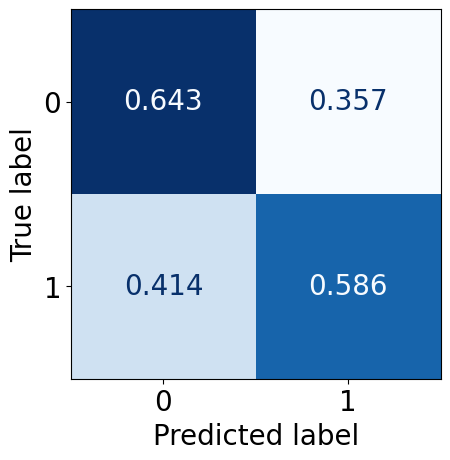

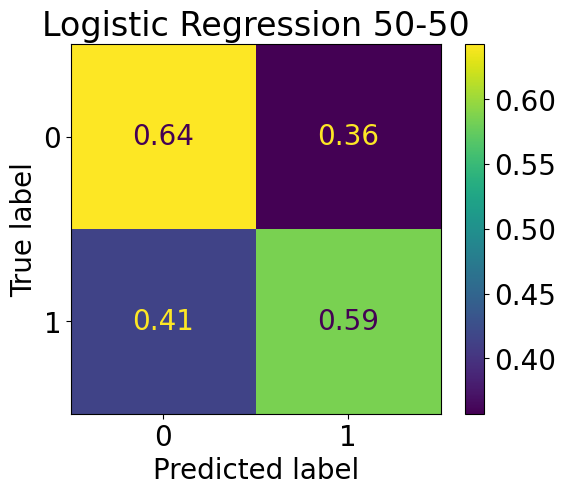

Random Forest
0.7041310011164867
[[ 888  447]
 [ 348 1004]]


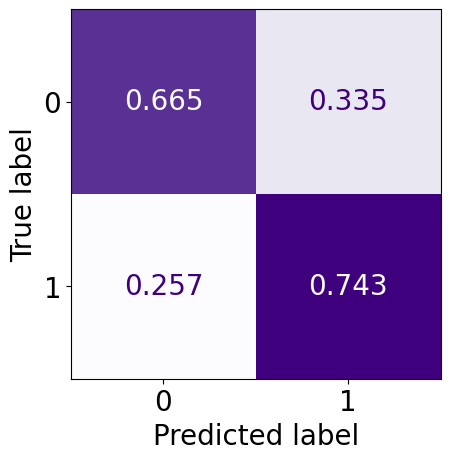

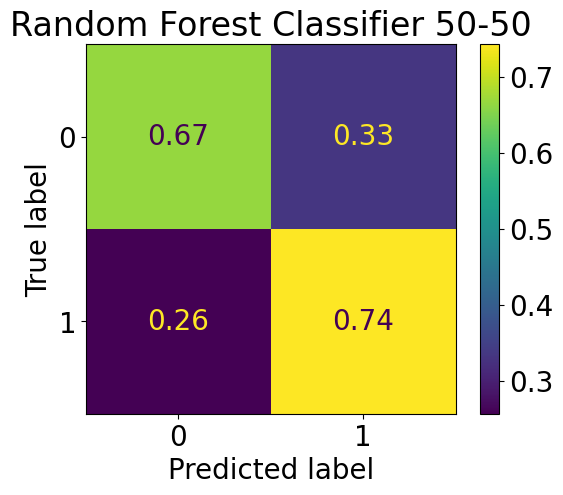

Gradient Boost
0.6687755861555639
[[871 464]
 [426 926]]


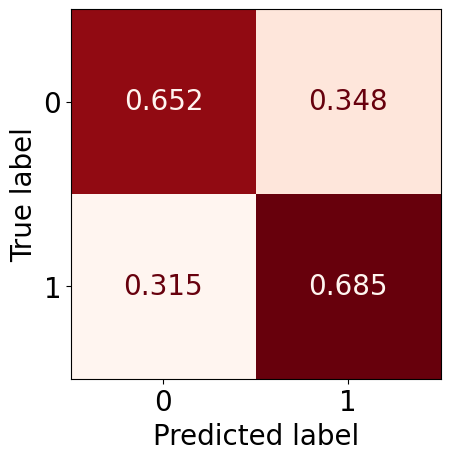

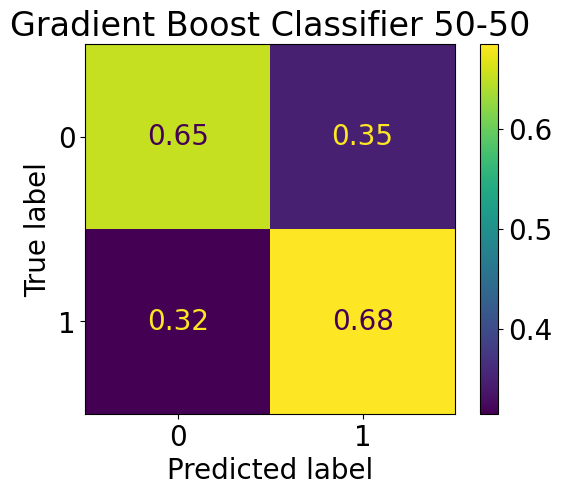

---------------------------
[5, 95]
---------------------------
789 15000
70 in test length of 1579 - 0.044331855604813175
Log Reg
0.9556681443951869
[[1509    0]
 [  70    0]]


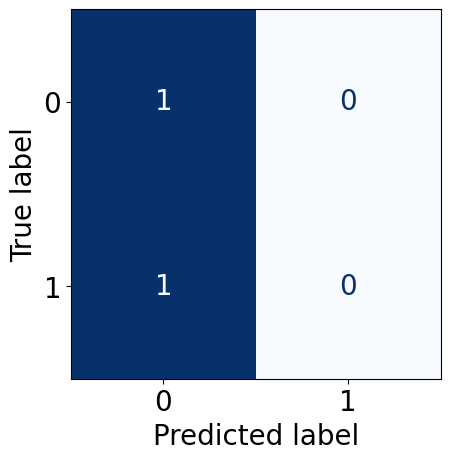

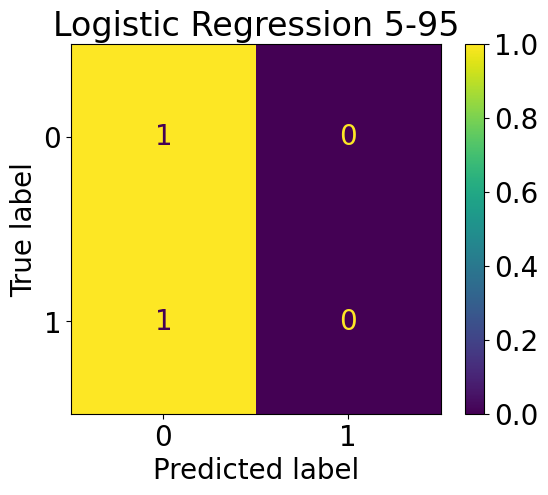

Random Forest
0.9556681443951869
[[1509    0]
 [  70    0]]


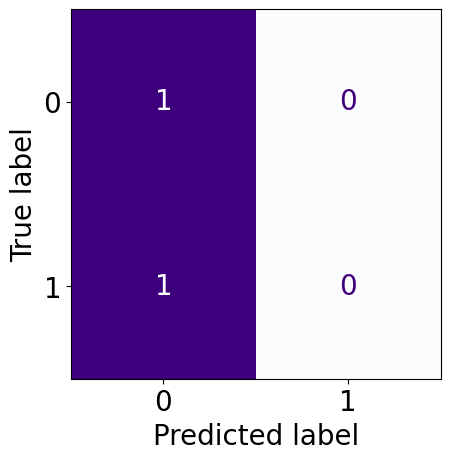

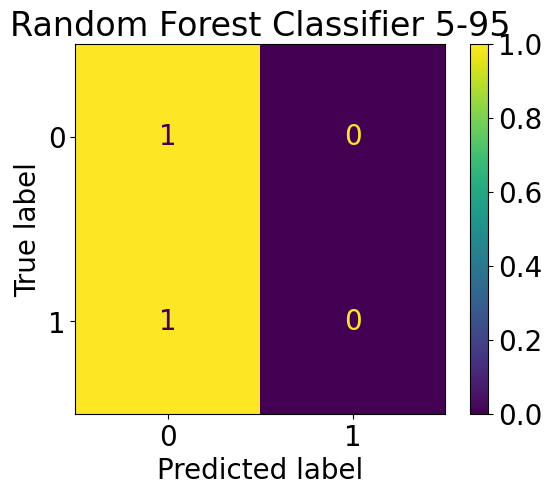

Gradient Boost
0.9550348321722609
[[1508    1]
 [  70    0]]


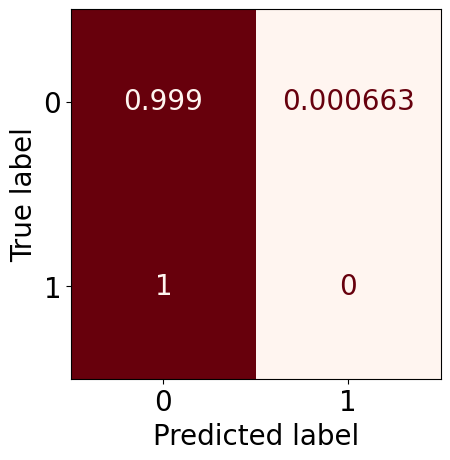

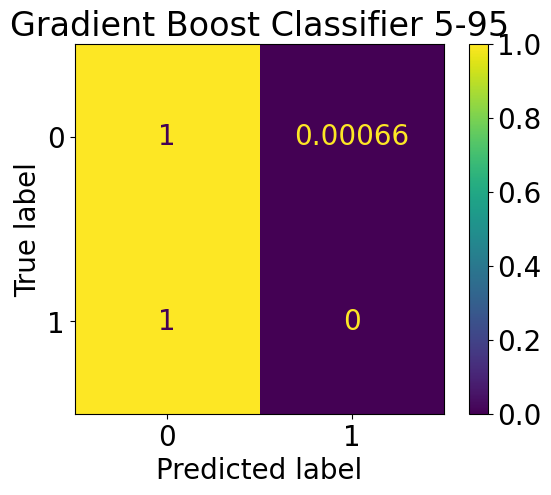

---------------------------
[20, 80]
---------------------------
3750 15000
383 in test length of 1875 - 0.20426666666666668
Log Reg
0.7866666666666666
[[1474   18]
 [ 382    1]]


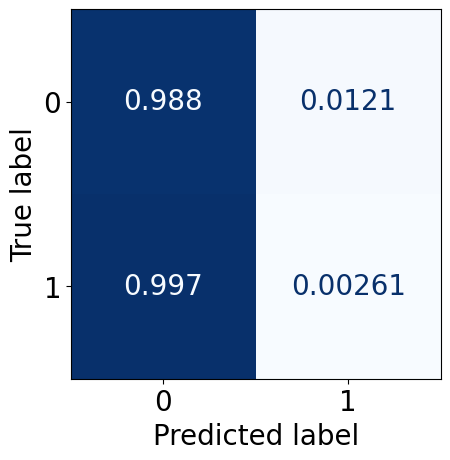

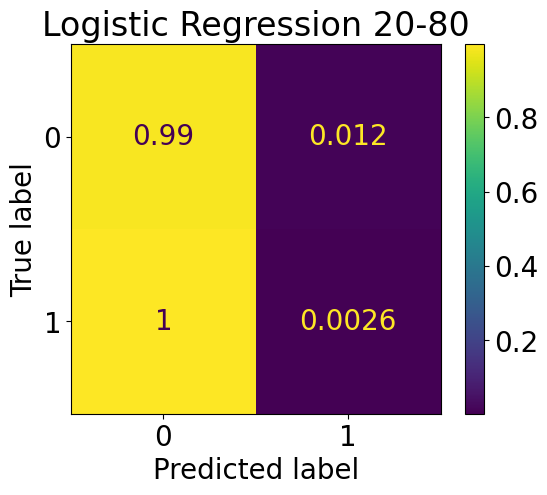

Random Forest
0.7989333333333334
[[1484    8]
 [ 369   14]]


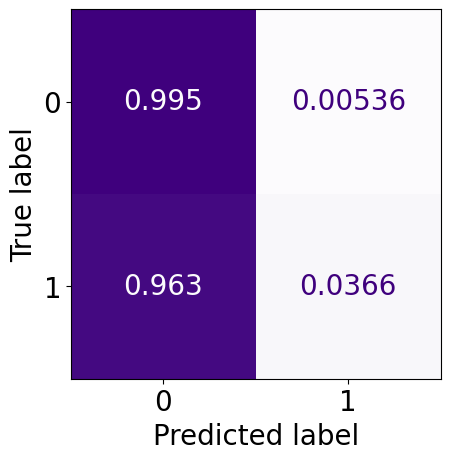

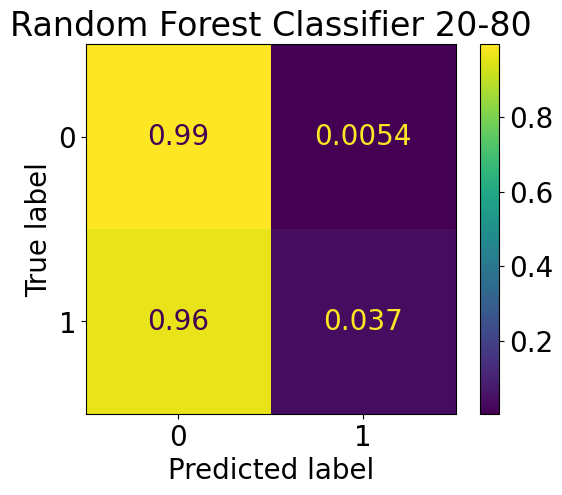

Gradient Boost
0.7984
[[1490    2]
 [ 376    7]]


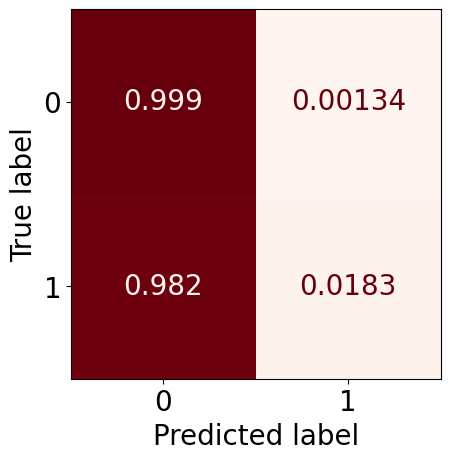

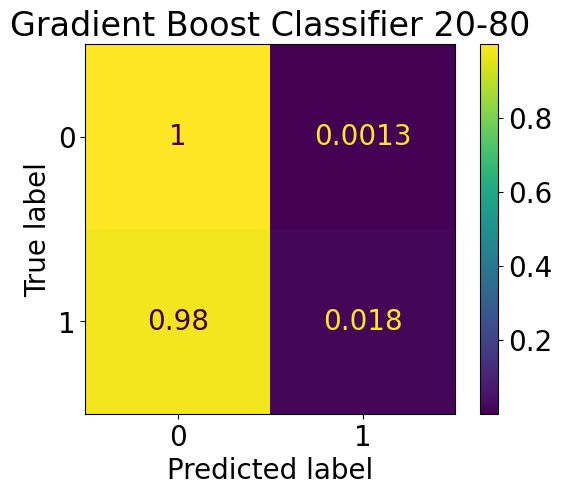

---------------------------
[30, 70]
---------------------------
6428 15000
609 in test length of 2143 - 0.2841810545963602
Log Reg
0.6962202519832011
[[1445   89]
 [ 562   47]]


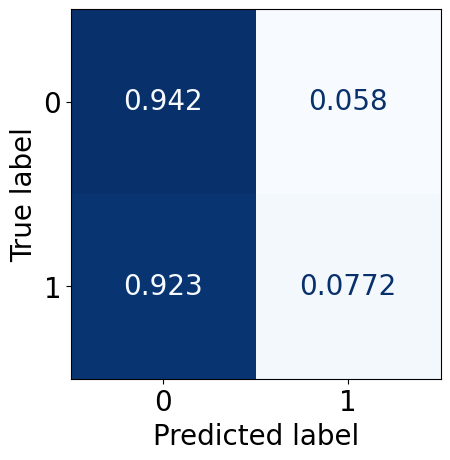

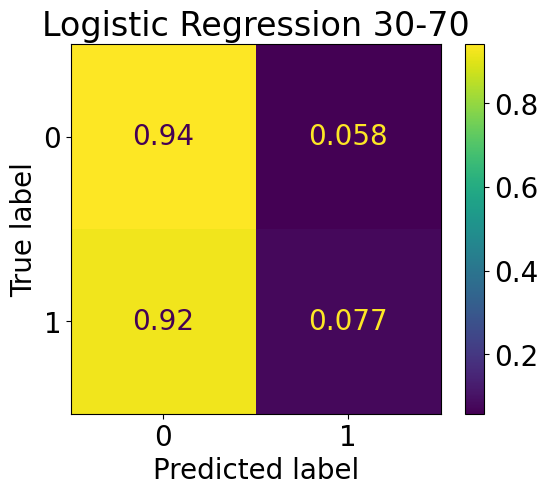

Random Forest
0.7228184787680821
[[1381  153]
 [ 441  168]]


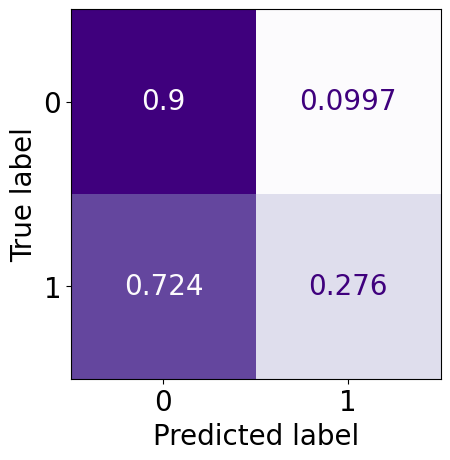

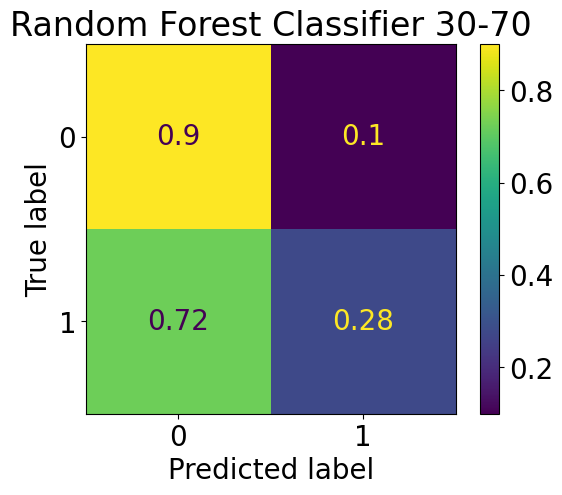

Gradient Boost
0.7148856742883808
[[1451   83]
 [ 528   81]]


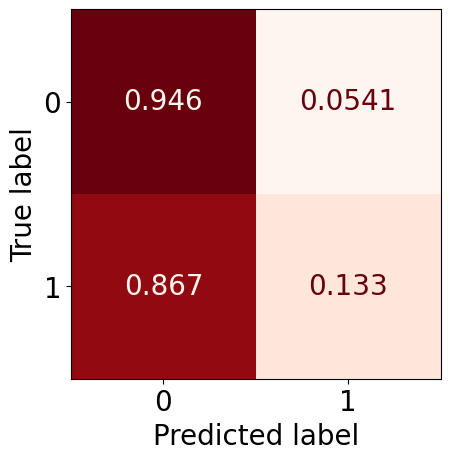

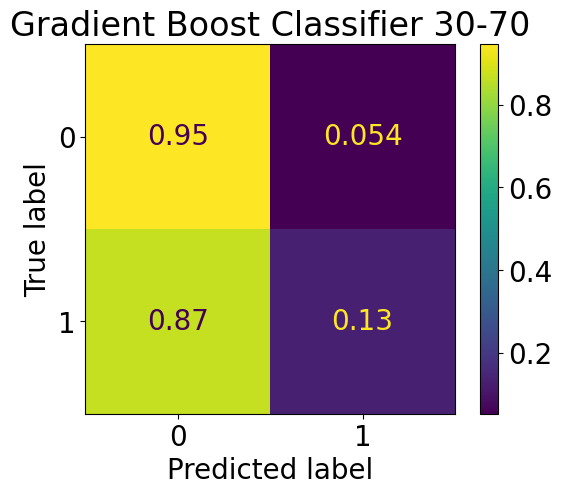

---------------------------
[40, 60]
---------------------------
10000 15000
1002 in test length of 2500 - 0.4008
Log Reg
0.5888
[[1254  244]
 [ 784  218]]


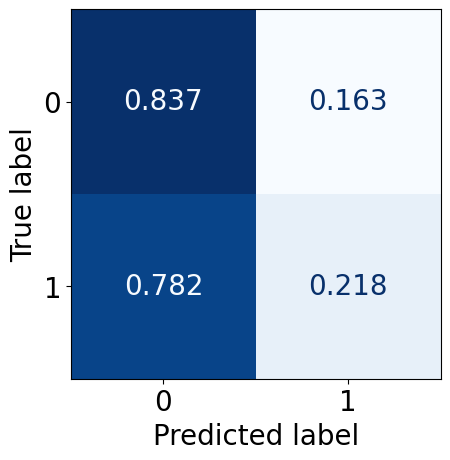

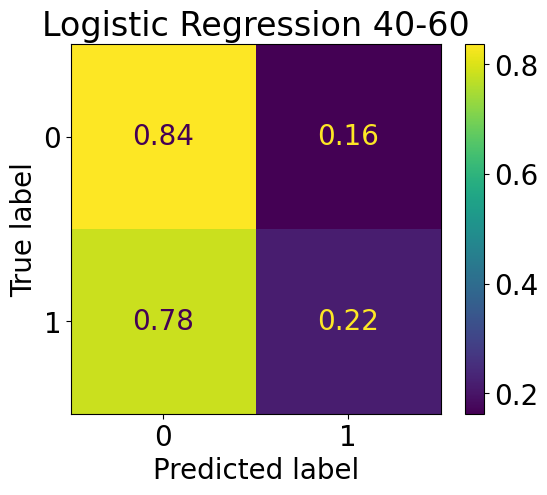

Random Forest
0.6888
[[1143  355]
 [ 423  579]]


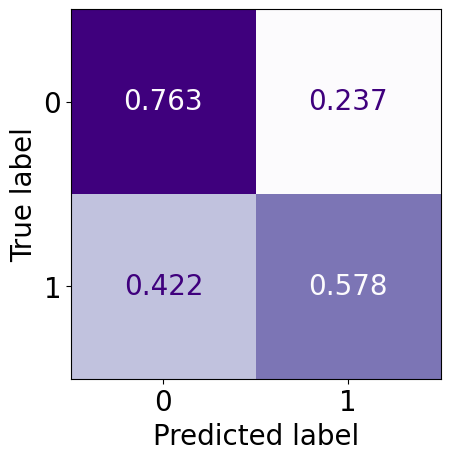

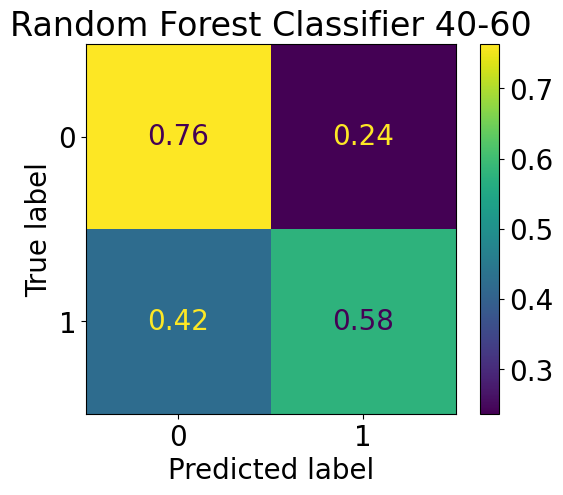

Gradient Boost
0.6528
[[1183  315]
 [ 553  449]]


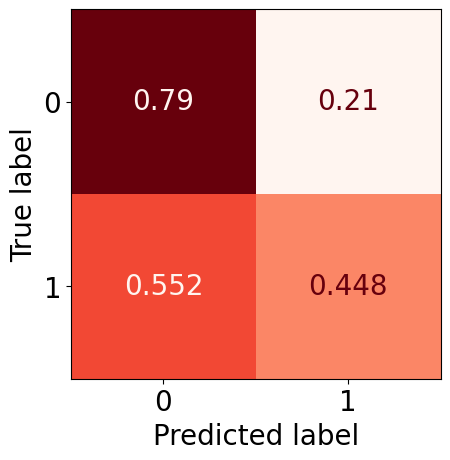

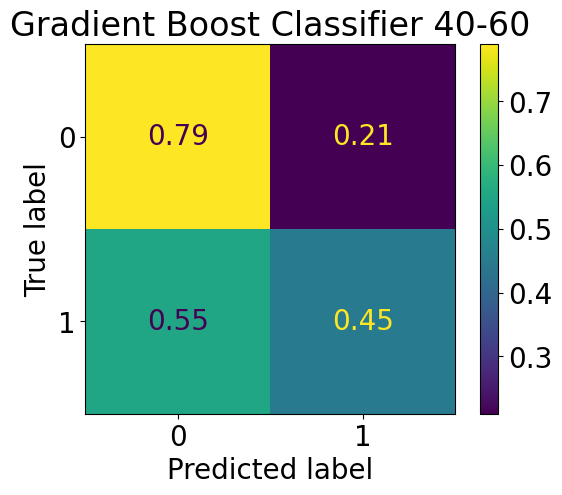

In [ ]:
for split in testingSplits:
  print("---------------------------")
  print(split)
  print("---------------------------")
  total = firesCount*2
  fireCount = int((split[0]/100)*total)
  noFireCount = total-fireCount

  if (noFireCount > noFiresCount):
    noFireCount = noFiresCount
    fireCount = int(noFireCount/(split[1]/100))-noFireCount

  print(fireCount, noFireCount)
  trainX, trainY = generateDataSplits(fireCount, noFireCount)

  X_train, X_test, y_train, y_test = train_test_split(trainX, trainY, test_size=0.1, random_state=0)
  print(np.count_nonzero(y_test), "in test length of", len(y_test), "-", np.count_nonzero(y_test)/len(y_test))

  print("Log Reg")
  logreg_base.fit(X_train, y_train.ravel())
  print(logreg_base.score(X_test, y_test))
  print(confusion_matrix(y_test, logreg_base.predict(X_test)))
  ConfusionMatrixDisplay.from_predictions(
      y_true = y_test, y_pred = logreg_base.predict(X_test), normalize="true",
      display_labels=logreg_base.classes_,
      colorbar=False, cmap="Blues", values_format=".3g"
    ).plot()
  plt.title(f"Logistic Regression {split[0]}-{split[1]}")
  plt.show()

  print("Random Forest")
  rfreg_base.fit(X_train, y_train)
  print(rfreg_base.score(X_test, y_test))
  print(confusion_matrix(y_test, rfreg_base.predict(X_test)))
  ConfusionMatrixDisplay.from_predictions(
      y_true = y_test, y_pred = rfreg_base.predict(X_test), normalize="true",
      display_labels=rfreg_base.classes_,
      colorbar=False, cmap="Purples", values_format=".3g"
    ).plot()
  plt.title(f"Random Forest Classifier {split[0]}-{split[1]}")
  plt.show()

  print("Gradient Boost")
  gbreg_base.fit(X_train, y_train)
  print(gbreg_base.score(X_test, y_test))
  print(confusion_matrix(y_test, gbreg_base.predict(X_test)))
  ConfusionMatrixDisplay.from_predictions(
      y_true = y_test, y_pred = gbreg_base.predict(X_test), normalize="true",
      display_labels=gbreg_base.classes_,
      colorbar=False, cmap="Reds", values_format=".3g"
    ).plot()
  plt.title(f"Gradient Boost Classifier {split[0]}-{split[1]}")
  plt.show()

  with open(splitPath+f"logreg_{split[0]}_{split[1]}.pkl", 'wb') as f:
    pickle.dump(logreg_base, f)
  with open(splitPath+f"randomf_{split[0]}_{split[1]}.pkl", 'wb') as f:
    pickle.dump(rfreg_base, f)
  with open(splitPath+f"gradient_{split[0]}_{split[1]}.pkl", 'wb') as f:
    pickle.dump(gbreg_base, f)

#### K-fold Cross Validation with Best Split

In [ ]:
split = "50:50"

In [ ]:
X_train_total, Y_train_total = generateDataSplits(13433 , 13433)
trainX, X_test, trainY, y_test = train_test_split(X_train_total, Y_train_total, test_size=0.1, random_state=0)

In [ ]:
def train_logreg_base(savePath):
  print("logreg")
  accuracies_lg = []
  models_lg = []

  for i in range(10):
    print(i)
    intervalStart, intervalEnd = int(i*(trainX.shape[0]/10)), int((i+1)*(trainX.shape[0]/10))
    # test_x, test_y = trainX[intervalStart:intervalEnd], trainY[intervalStart:intervalEnd]
    train_x, train_y = np.concatenate((trainX[:intervalStart], trainX[intervalEnd:])), np.concatenate((trainY[:intervalStart], trainY[intervalEnd:])).ravel()
    logreg_base.fit(train_x, train_y)
    accuracies_lg.append(logreg_base.score(X_test, y_test))
    models_lg.append(logreg_base)
    print(accuracies_lg[i])

    # Display
    print(confusion_matrix(y_test, logreg_base.predict(X_test)))
    ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, logreg_base.predict(X_test)), display_labels=logreg_base.classes_).plot()
    plt.title(f"Logistic Regression {i}")
    plt.show()

  with open(basePath+split+"/logistic_base.pkl", 'wb') as f:
    pickle.dump(models_lg, f)
  np.save(basePath+split+"/logistic_base_acc", accuracies_lg)

  print(accuracies_lg)


In [ ]:
def train_rf_base(split):
  accuracies_rf = []
  models_rf = []
  print("random forest")

  for i in range(10):
    print(i)
    intervalStart, intervalEnd = int(i*(trainX.shape[0]/10)), int((i+1)*(trainX.shape[0]/10))
    # test_x, test_y = trainX[intervalStart:intervalEnd], trainY[intervalStart:intervalEnd]
    train_x, train_y = np.concatenate((trainX[:intervalStart], trainX[intervalEnd:])), np.concatenate((trainY[:intervalStart], trainY[intervalEnd:])).ravel()
    rfreg_base.fit(train_x, train_y)
    accuracies_rf.append(rfreg_base.score(X_test, y_test))
    models_rf.append(rfreg_base)
    print(accuracies_rf[i])

    # Display
    print(confusion_matrix(y_test, rfreg_base.predict(X_test)))
    ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, rfreg_base.predict(X_test)), display_labels=rfreg_base.classes_).plot()
    plt.title(f"Random Forest Classifier {split[0]}-{split[1]}")
    plt.show()

  with open(basePath+split+"/random_forest_base.pkl", 'wb') as f:
    pickle.dump(models_rf, f)
  np.save(basePath+split+"/random_forest_acc", accuracies_rf)

In [ ]:
def train_gb_base(split):
  accuracies_gb = []
  models_gb = []

  for i in range(10):
    print(i)
    intervalStart, intervalEnd = int(i*(trainX.shape[0]/10)), int((i+1)*(trainX.shape[0]/10))
    # test_x, test_y = trainX[intervalStart:intervalEnd], trainY[intervalStart:intervalEnd]
    train_x, train_y = np.concatenate((trainX[:intervalStart], trainX[intervalEnd:])), np.concatenate((trainY[:intervalStart], trainY[intervalEnd:])).ravel()
    gbreg_base.fit(train_x, train_y)
    accuracies_gb.append(gbreg_base.score(X_test, y_test))
    models_gb.append(gbreg_base)
    print(accuracies_gb[i])

    print(confusion_matrix(y_test, gbreg_base.predict(X_test)))
    ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, gbreg_base.predict(X_test)), display_labels=gbreg_base.classes_).plot()
    plt.title(f"Gradient Boost Classifier {split[0]}-{split[1]}")
    plt.show()

  with open(basePath+split+"/gradient_boost_base.pkl", 'wb') as f:
    pickle.dump(models_gb, f)
  np.save(basePath+split+"/gradient_boost_acc", accuracies_gb)


### Confusion Matrices and Training Steps

logreg
0
0.6103461109043543
[[860 475]
 [572 780]]


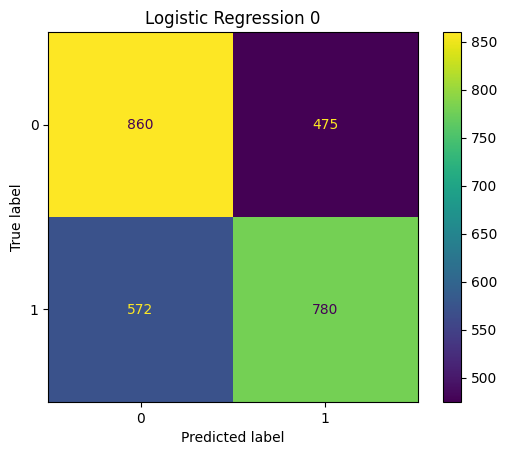

1
0.6159285448455527
[[862 473]
 [559 793]]


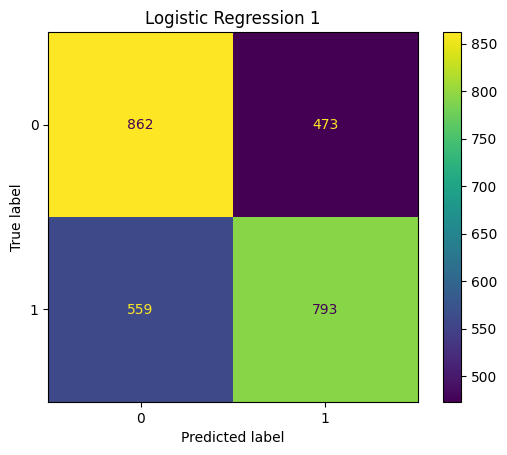

2
0.6114625976925939
[[863 472]
 [572 780]]


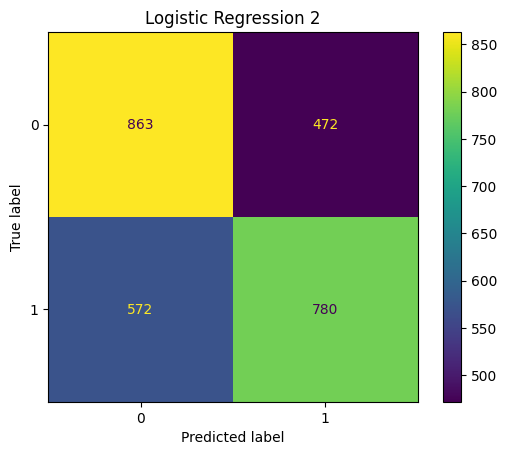

3
0.6140677335318199
[[877 458]
 [579 773]]


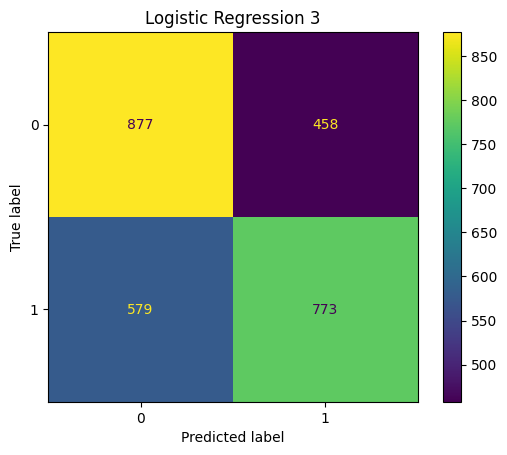

4
0.6129512467435801
[[868 467]
 [573 779]]


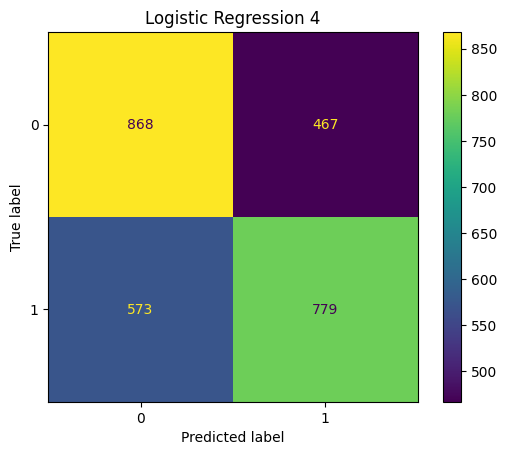

5
0.6170450316337923
[[870 465]
 [564 788]]


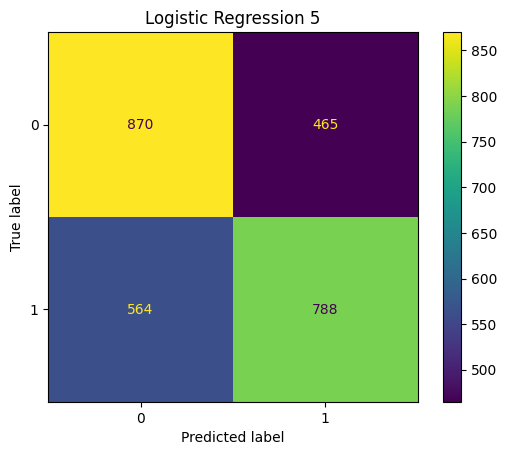

6
0.6103461109043543
[[856 479]
 [568 784]]


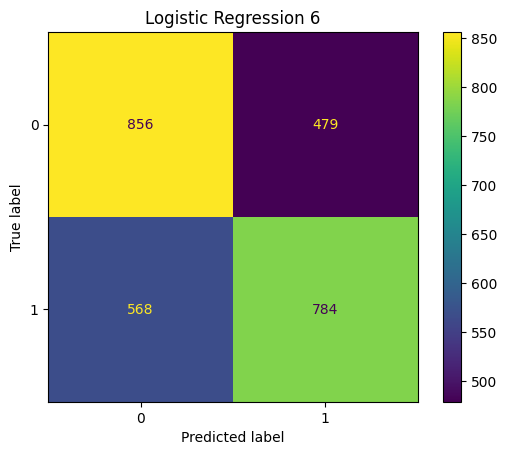

7
0.614812058057313
[[874 461]
 [574 778]]


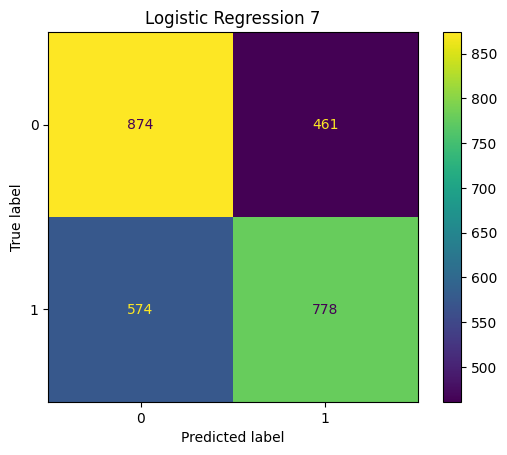

8
0.6200223297357648
[[872 463]
 [558 794]]


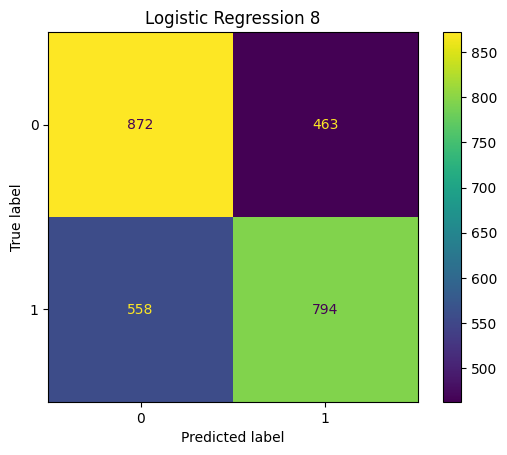

9
0.6062523260141421
[[862 473]
 [585 767]]


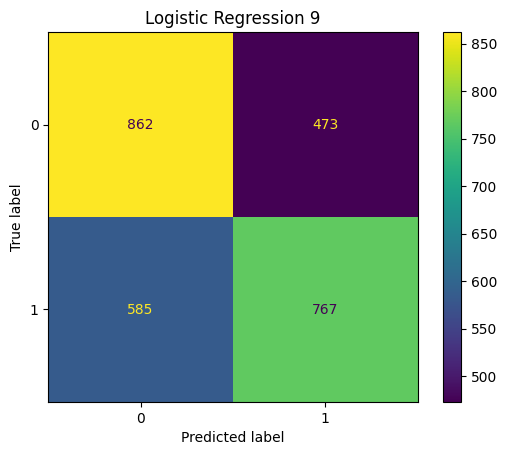

[0.6103461109043543, 0.6159285448455527, 0.6114625976925939, 0.6140677335318199, 0.6129512467435801, 0.6170450316337923, 0.6103461109043543, 0.614812058057313, 0.6200223297357648, 0.6062523260141421]


In [ ]:
train_logreg_base(split)

random forest
0
0.6908
[[1160  338]
 [ 435  567]]


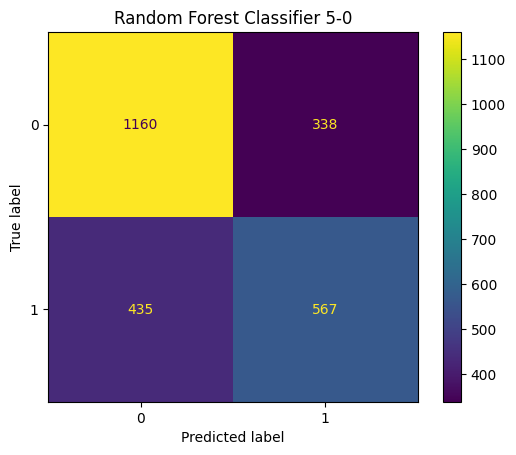

1
0.6848
[[1151  347]
 [ 441  561]]


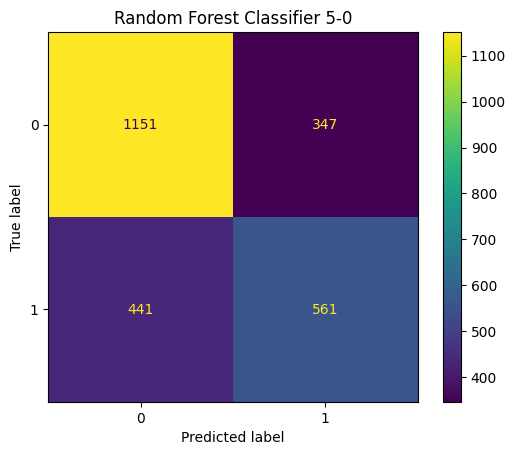

2
0.6872
[[1154  344]
 [ 438  564]]


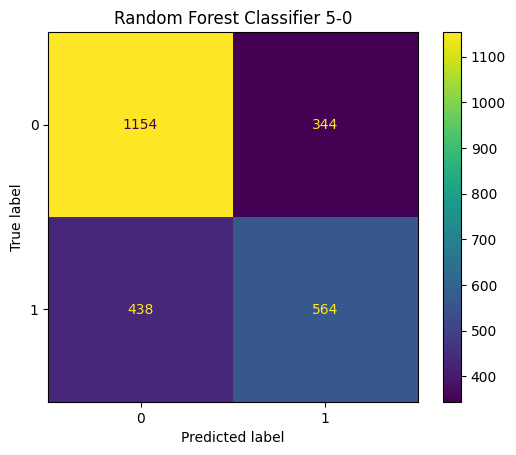

3
0.6888
[[1168  330]
 [ 448  554]]


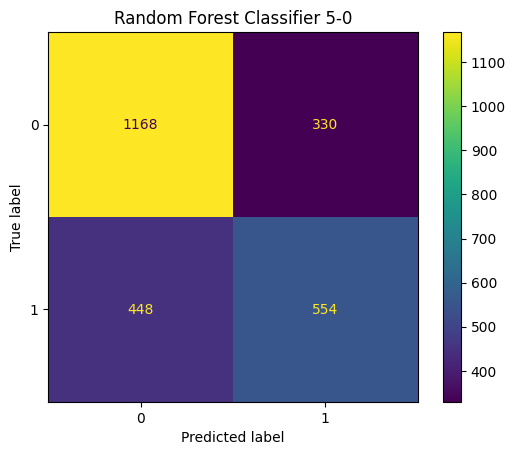

4
0.6808
[[1128  370]
 [ 428  574]]


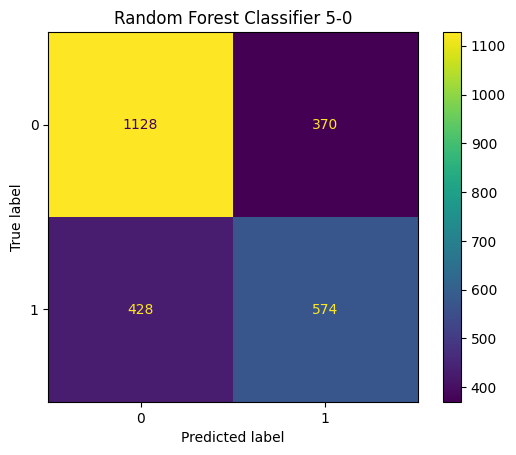

5
0.682
[[1153  345]
 [ 450  552]]


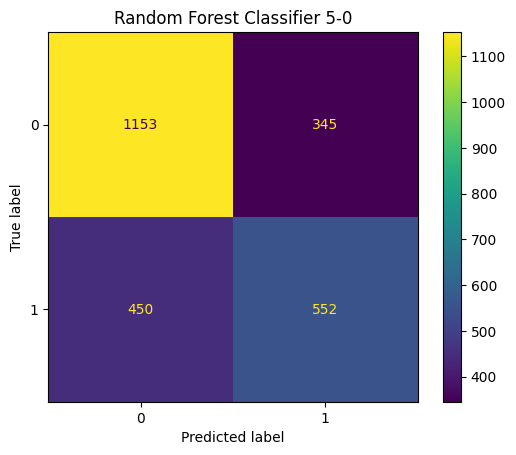

6
0.6792
[[1139  359]
 [ 443  559]]


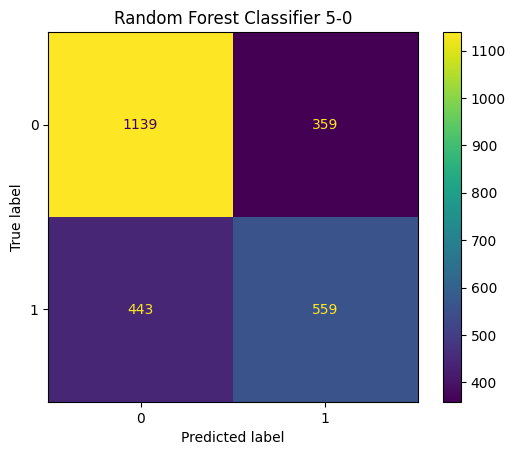

7
0.6872
[[1157  341]
 [ 441  561]]


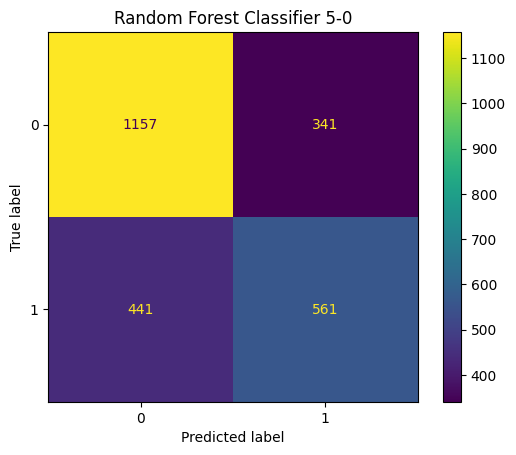

8
0.6872
[[1160  338]
 [ 444  558]]


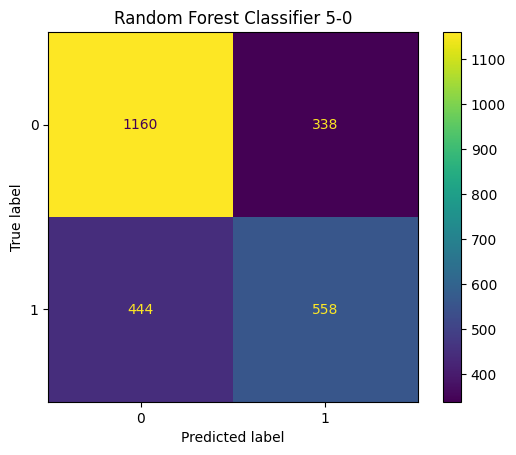

9
0.6816
[[1149  349]
 [ 447  555]]


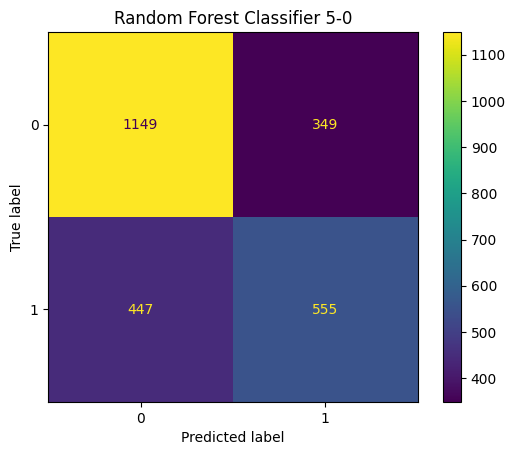

In [ ]:
train_rf_base(split)

0
0.6452
[[1182  316]
 [ 571  431]]


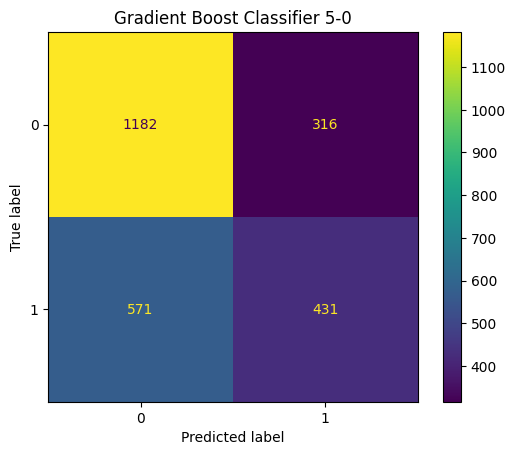

1
0.6584
[[1185  313]
 [ 541  461]]


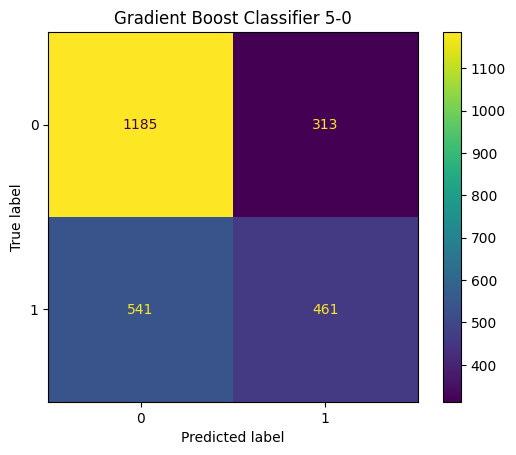

2
0.6568
[[1188  310]
 [ 548  454]]


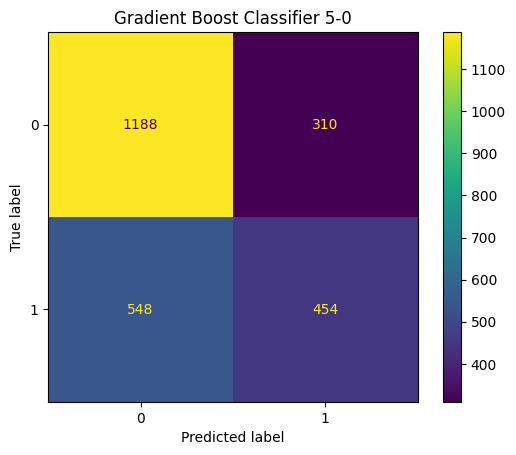

3
0.6512
[[1196  302]
 [ 570  432]]


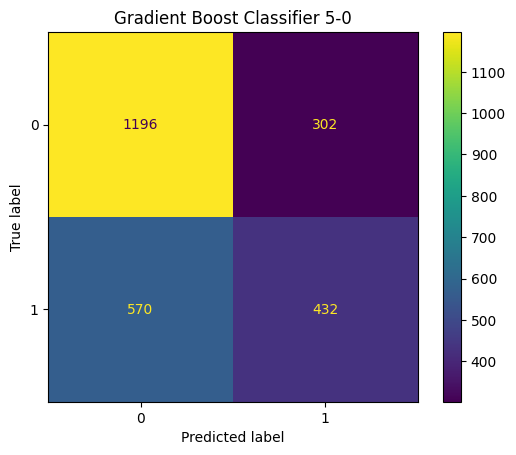

4
0.652
[[1176  322]
 [ 548  454]]


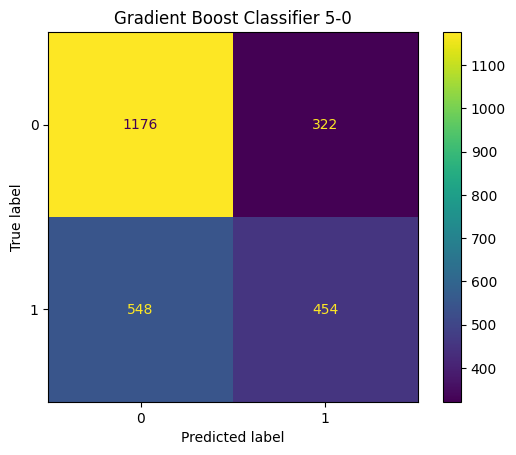

5
0.6508
[[1182  316]
 [ 557  445]]


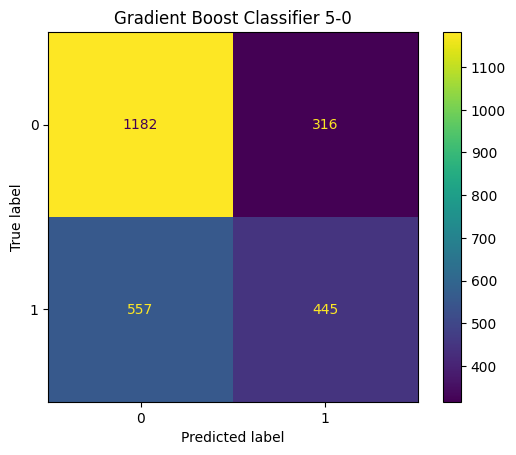

6
0.6552
[[1180  318]
 [ 544  458]]


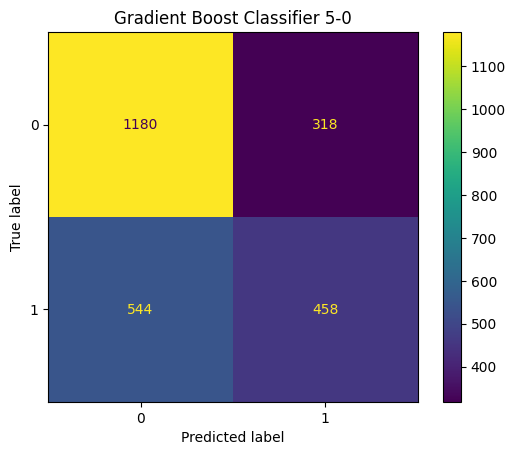

7
0.6544
[[1178  320]
 [ 544  458]]


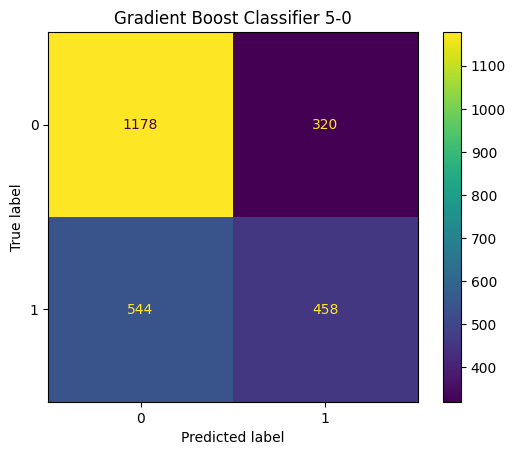

8
0.6528
[[1192  306]
 [ 562  440]]


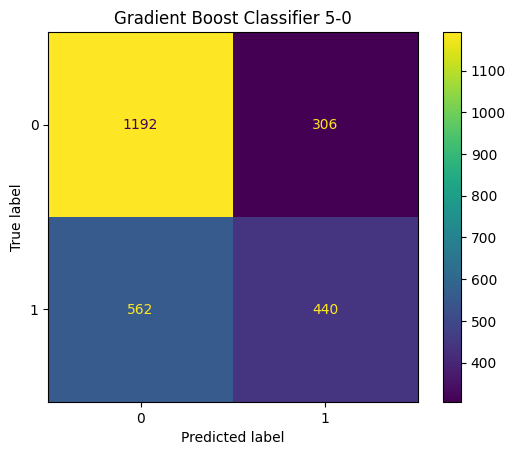

9
0.652
[[1182  316]
 [ 554  448]]


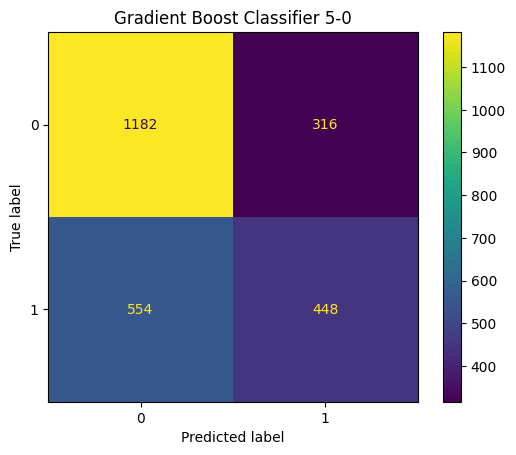

In [ ]:
train_gb_base(split)

### Analysis and Importing Models

In [ ]:
X_train_total, Y_train_total = generateDataSplits(13433 , 13433)
trainX, X_test, trainY, y_test = train_test_split(X_train_total, Y_train_total, test_size=0.1, random_state=0)

In [ ]:
split = "50:50"

In [ ]:
accuracies_gb = np.load(basePath+split+"/gradient_boost_acc.npy")
accuracies_rf = np.load(basePath+split+"/random_forest_acc.npy")
accuracies_lg = np.load(basePath+split+"/logistic_base_acc.npy")

In [ ]:
models_gb = pickle.load(open(basePath+split+"/gradient_boost_base.pkl", 'rb'))
models_rf = pickle.load(open(basePath+split+"/random_forest_base.pkl", 'rb'))
models_lg = pickle.load(open(basePath+split+"/logistic_base.pkl", 'rb'))

In [ ]:
model_gb = models_gb[accuracies_gb.argmax(axis=0)]
model_rf = models_rf[accuracies_rf.argmax(axis=0)]
model_lg = models_lg[accuracies_lg.argmax(axis=0)]
acc_gb, acc_rf, acc_lg = accuracies_gb[accuracies_gb.argmax(axis=0)], accuracies_rf[accuracies_rf.argmax(axis=0)], accuracies_lg[accuracies_lg.argmax(axis=0)]
acc_gb, acc_rf, acc_lg

(0.6584, 0.6908, 0.6200223297357648)

In [ ]:
np.std(accuracies_lg), np.std(accuracies_rf), np.std(accuracies_gb)

(0.0037364794634941988, 0.003666933323637065, 0.003481608823518231)

In [ ]:
np.average(accuracies_gb), np.average(accuracies_rf), np.average(accuracies_lg)

(0.65288, 0.68496, 0.6133234090063268)

In [ ]:
axis = [0, 1]
font = {'size' : 20}

plt.rc('font', **font)

### ROC AUC Curve

In [ ]:
def plot_roc_curve(true_y, y_prob, title, color):
    """
    plots the roc curve based of the probabilities
    """

    fpr, tpr, thresholds = roc_curve(true_y, y_prob)
    plt.plot(fpr, tpr, color=color)
    plt.title(title)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()

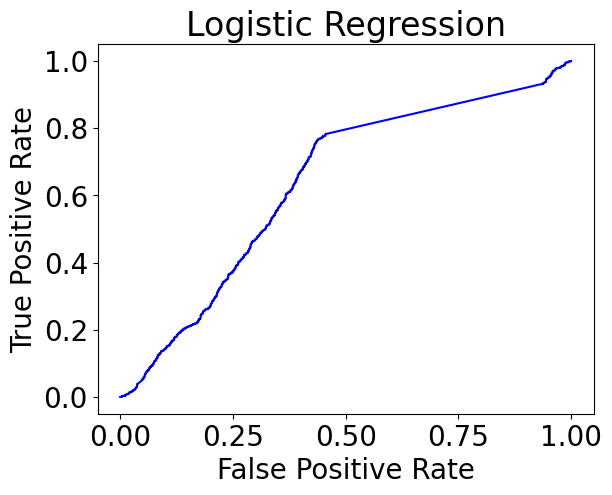

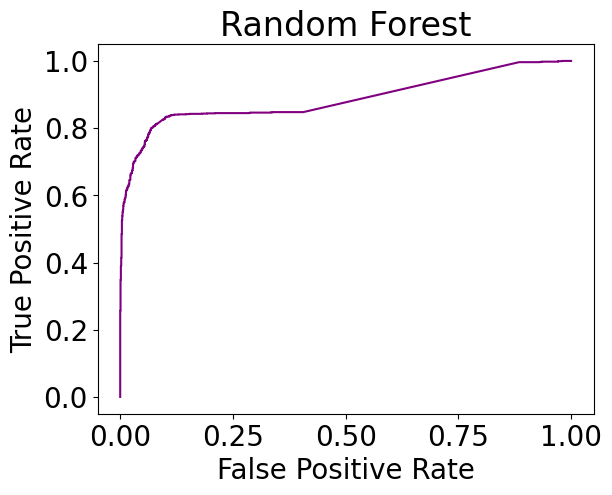

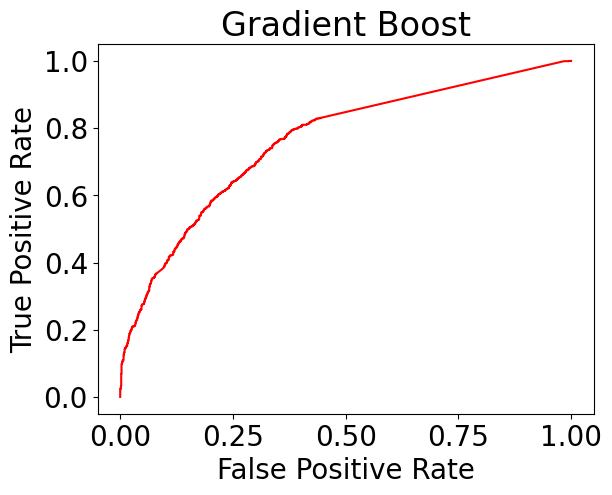

In [ ]:
plot_roc_curve(y_test, model_lg.predict_proba(X_test)[:, 1], "Logistic Regression", "Blue")
plot_roc_curve(y_test, model_rf.predict_proba(X_test)[:, 1], "Random Forest", "Purple")
plot_roc_curve(y_test, model_gb.predict_proba(X_test)[:, 1], "Gradient Boost", "Red")

[[0.59571527 0.38145161]
 [0.40428473 0.61854839]]
Logistic Regression - Temporal
[[0.77360775 0.05507246]
 [0.22639225 0.94492754]]
Random Forest Classifier - Temporal
[[0.62582781 0.22971429]
 [0.37417219 0.77028571]]
Gradient Boost Classifier - Temporal


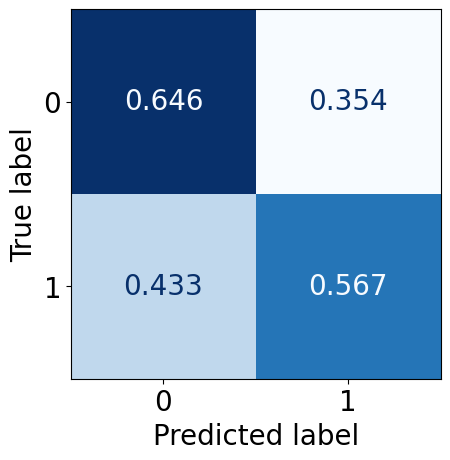

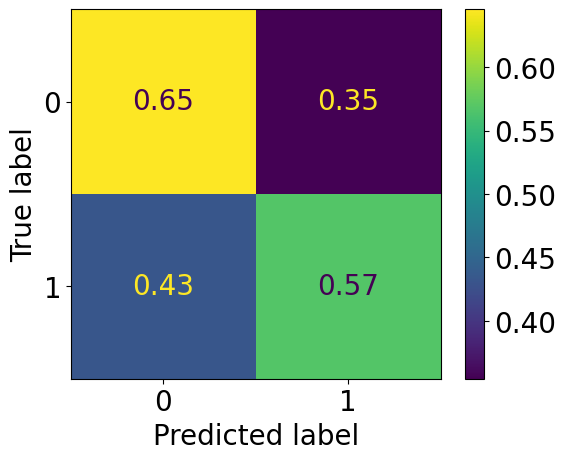

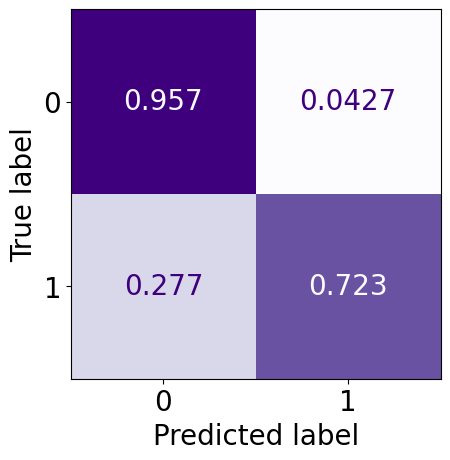

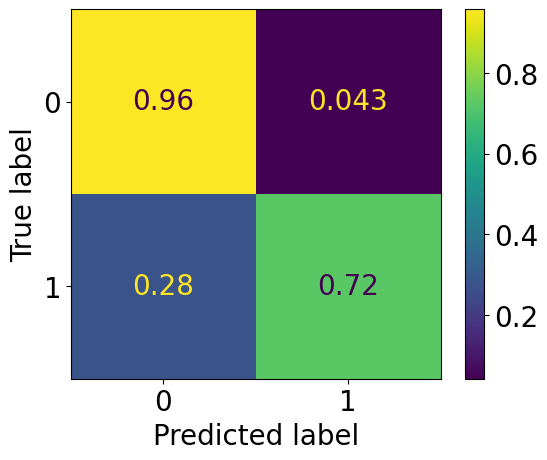

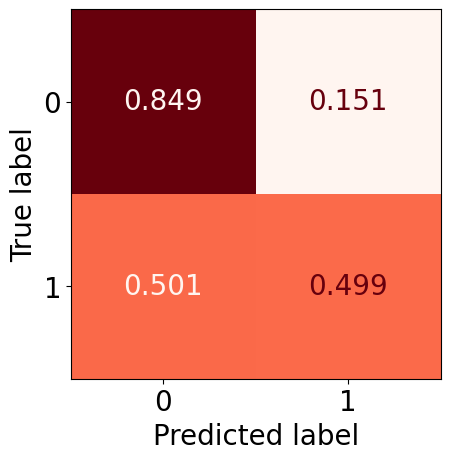

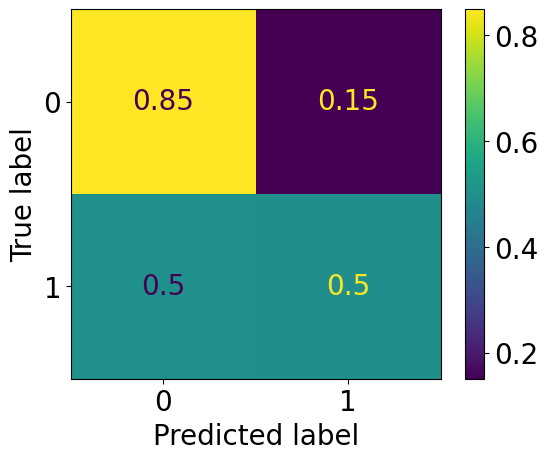

In [ ]:
print(confusion_matrix(y_test, model_lg.predict(X_test), normalize="pred"))
print("Logistic Regression - Temporal")
ConfusionMatrixDisplay.from_predictions(
    y_true=y_test, y_pred=model_lg.predict(X_test), normalize="true",
    display_labels=model_lg.classes_,
    colorbar=False, cmap="Blues", values_format=".3g"
  ).plot()

print(confusion_matrix(y_test, model_rf.predict(X_test), normalize="pred"))
print("Random Forest Classifier - Temporal")
ConfusionMatrixDisplay.from_predictions(
    y_true=y_test, y_pred=model_rf.predict(X_test), normalize="true",
    display_labels=model_rf.classes_,
    colorbar=False, cmap="Purples", values_format=".3g"
  ).plot()

print(confusion_matrix(y_test, model_gb.predict(X_test), normalize="pred"))
print("Gradient Boost Classifier - Temporal")
ConfusionMatrixDisplay.from_predictions(
    y_true=y_test, y_pred=model_gb.predict(X_test), normalize="true",
    display_labels=model_rf.classes_,
    colorbar=False, cmap="Reds", values_format=".3g"
  ).plot()

# ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, model_gb.predict(X_test), normalize="pred"), display_labels=model_gb.classes_).plot()
# plt.title(f"Gradient Boost Classifier - Temporal")
# plt.show()

### Mean Accuracy Decrease

In [ ]:
X_train_total, Y_train_total = generateDataSplits(13433 , 13433)
trainX, X_test, trainY, y_test = train_test_split(X_train_total, Y_train_total, test_size=0.1, random_state=0)

Hydrography
2687
Logistic
0.5485671752884258
0.07145515444733896
[[818 517]
 [696 656]]


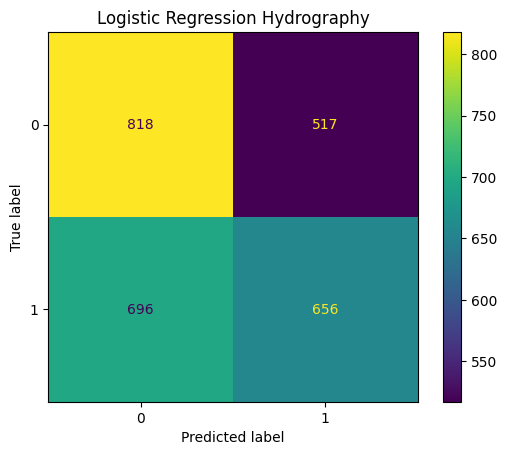

Random Forest
0.6724972087830294
0.018302791216970538
[[863 472]
 [408 944]]


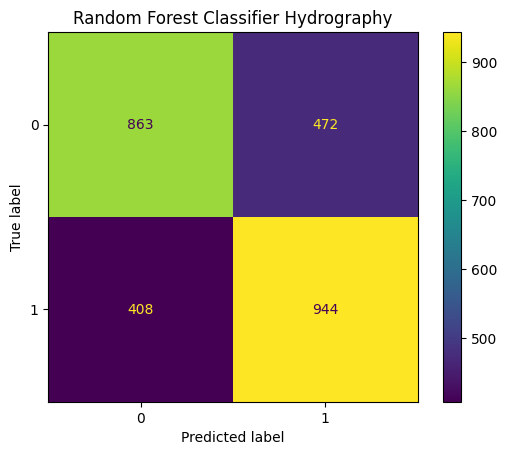

Gradient Boost
0.5973204317082248
0.06107956829177519
[[1091  244]
 [ 838  514]]


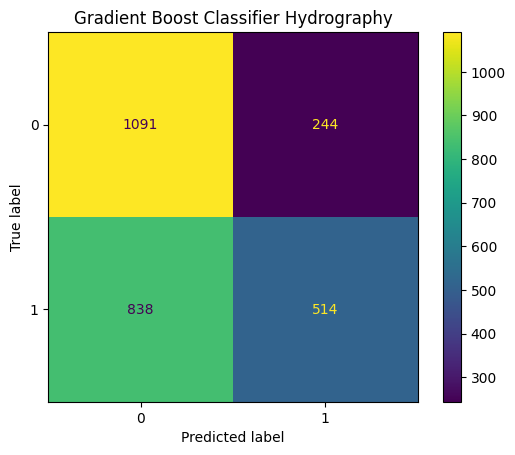

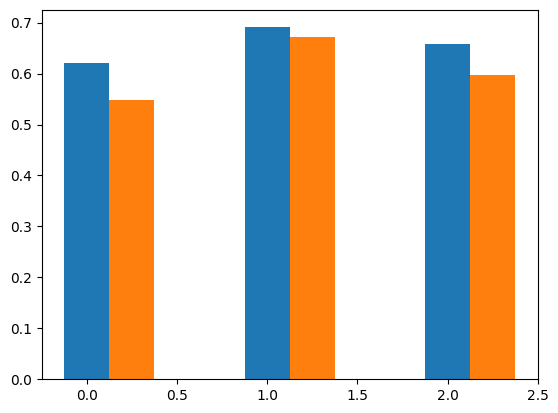

--------------------
Roads
2687
Logistic
0.6062523260141421
0.013770003721622626
[[833 502]
 [556 796]]


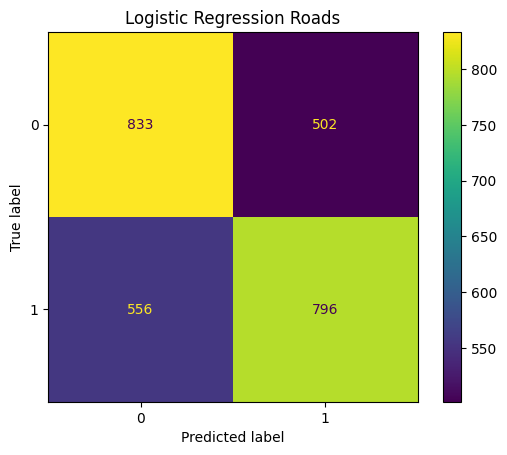

Random Forest
0.8347599553405285
-0.14395995534052852
[[1265   70]
 [ 374  978]]


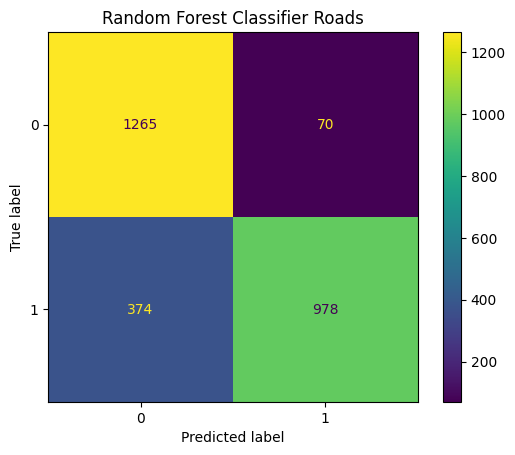

Gradient Boost
0.6717528842575363
-0.013352884257536335
[[1134  201]
 [ 681  671]]


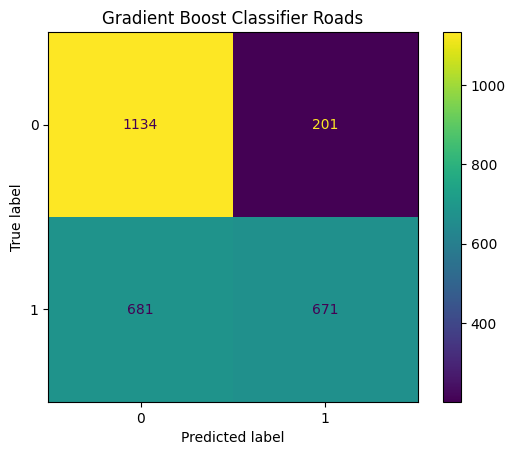

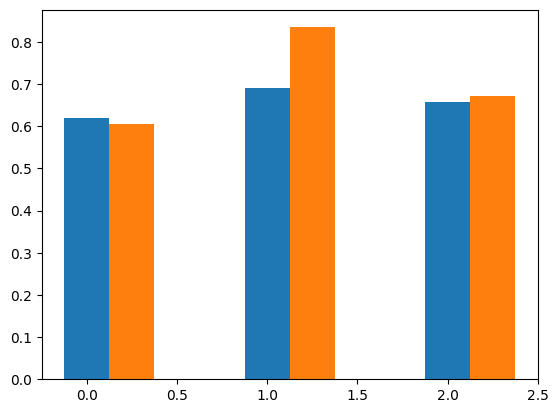

--------------------
Transmission Lines
2687
Logistic
0.6032750279121697
0.016747301823595073
[[858 477]
 [589 763]]


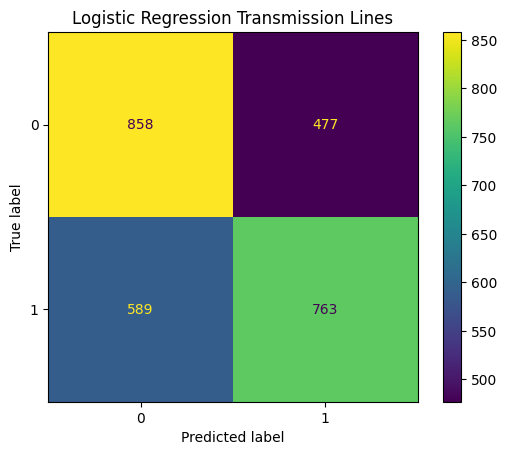

Random Forest
0.8336434685522888
-0.1428434685522888
[[1272   63]
 [ 384  968]]


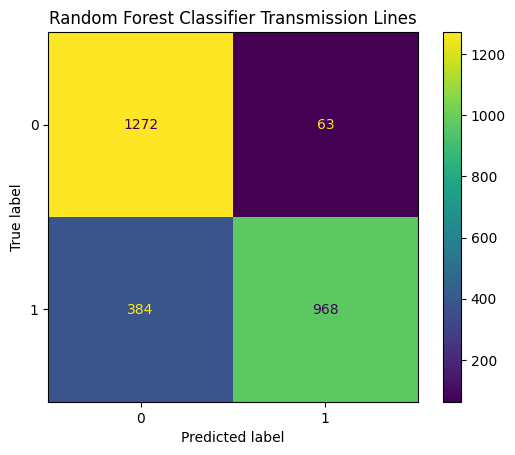

Gradient Boost
0.6728693710457759
-0.014469371045775947
[[1134  201]
 [ 678  674]]


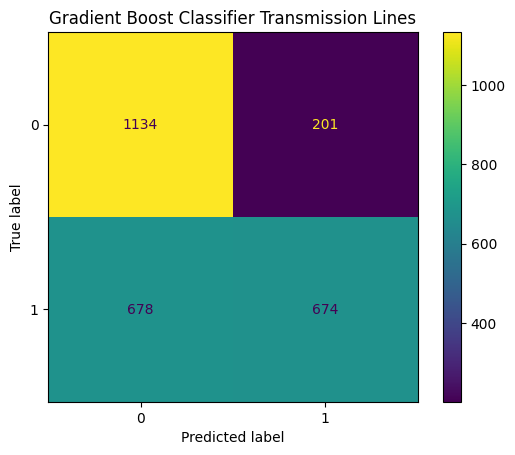

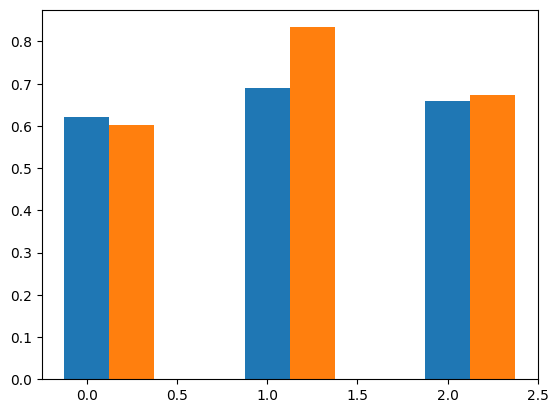

--------------------
Hardwood Forest
2687
Logistic
0.6058801637513956
0.014142165984369126
[[877 458]
 [601 751]]


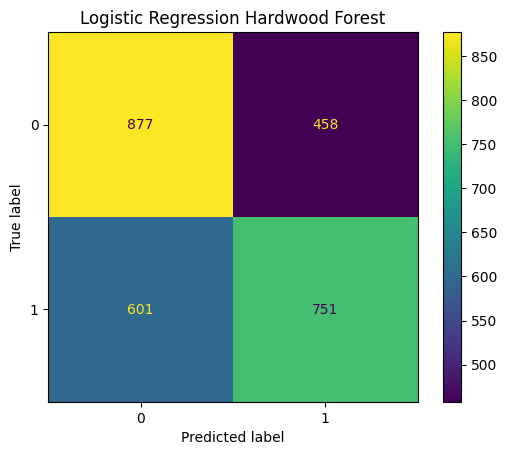

Random Forest
0.8399702270189803
-0.1491702270189803
[[1271   64]
 [ 366  986]]


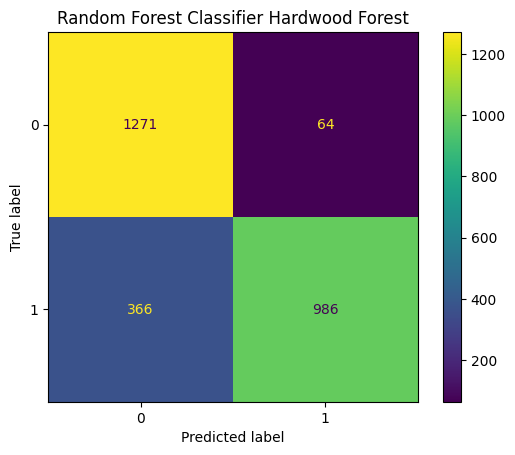

Gradient Boost
0.6654261257908448
-0.007026125790844828
[[1135  200]
 [ 699  653]]


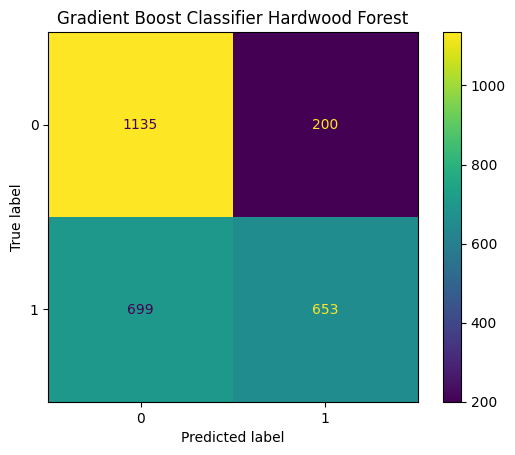

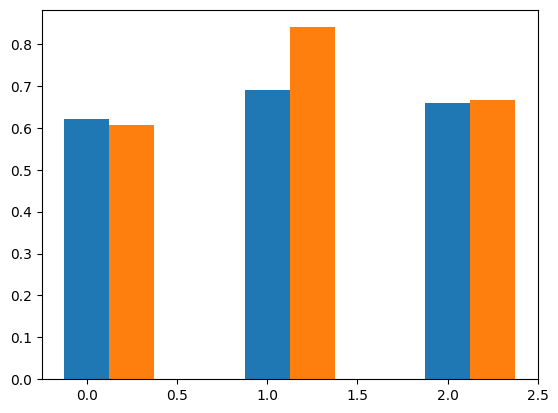

--------------------
Mixed Forest
2687
Logistic
0.5958317826572386
0.024190547078526192
[[891 444]
 [642 710]]


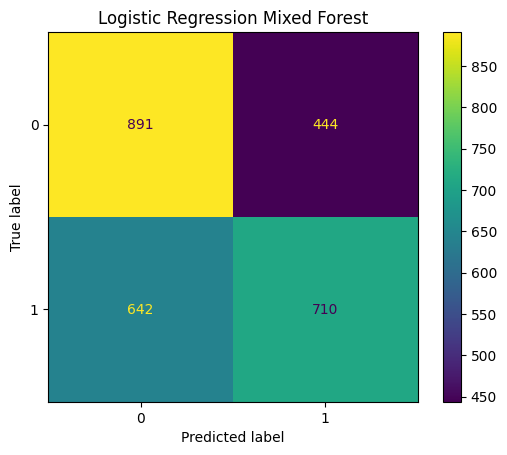

Random Forest
0.821734276144399
-0.130934276144399
[[1247   88]
 [ 391  961]]


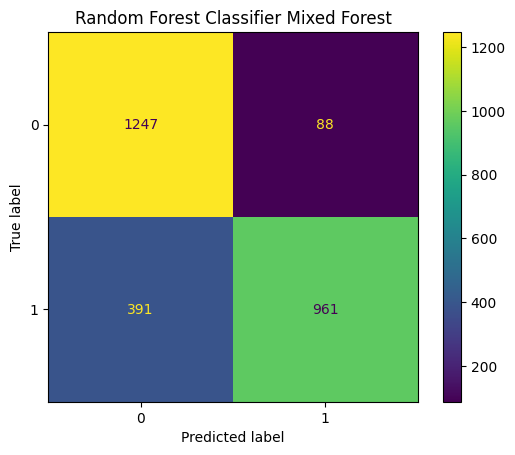

Gradient Boost
0.6527726088574618
0.005627391142538185
[[1143  192]
 [ 741  611]]


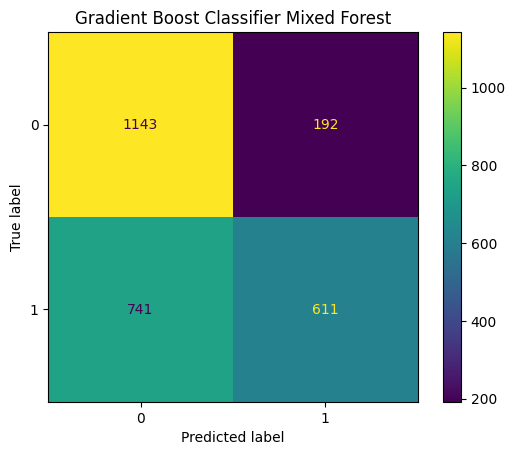

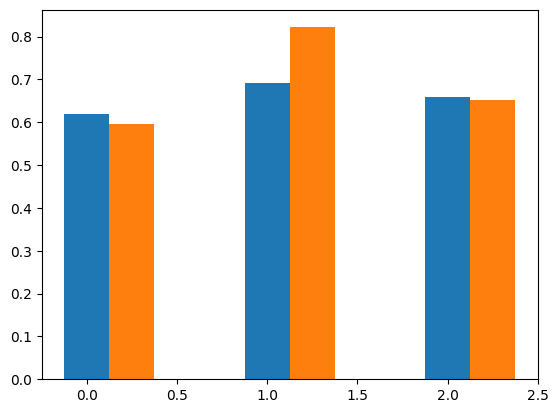

--------------------
Softwood Forest
2687
Logistic
0.5668031261630071
0.05321920357275767
[[887 448]
 [716 636]]


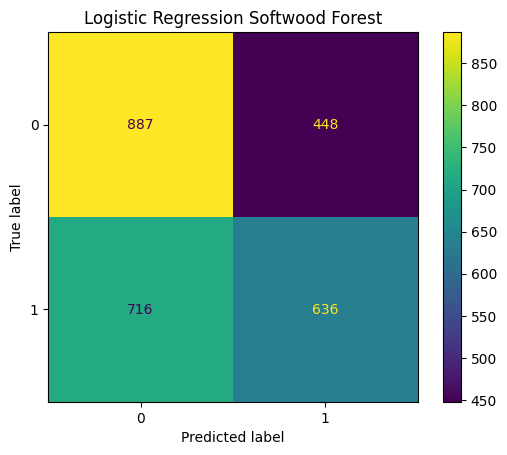

Random Forest
0.595459620394492
0.09534037960550801
[[803 532]
 [555 797]]


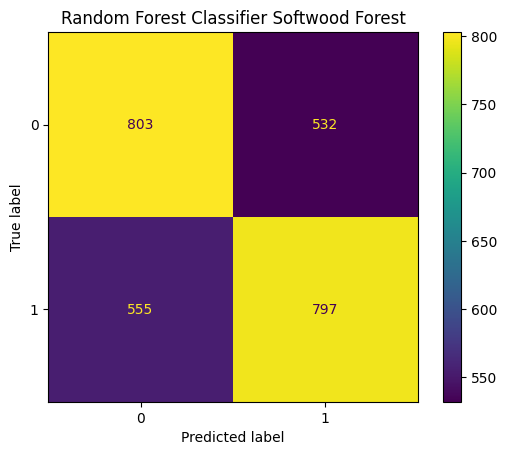

Gradient Boost
0.5530331224413845
0.10536687755861551
[[1054  281]
 [ 920  432]]


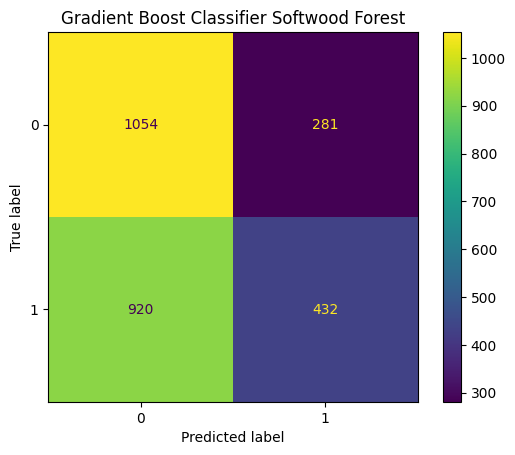

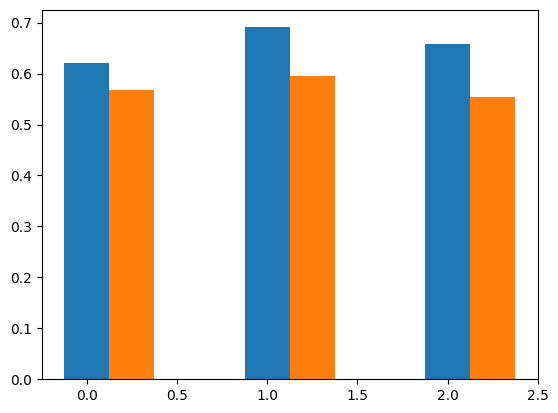

--------------------


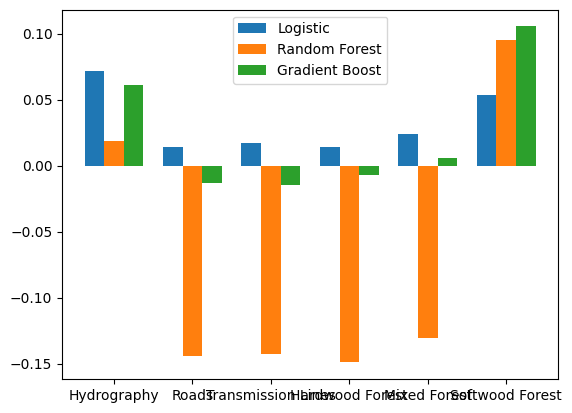

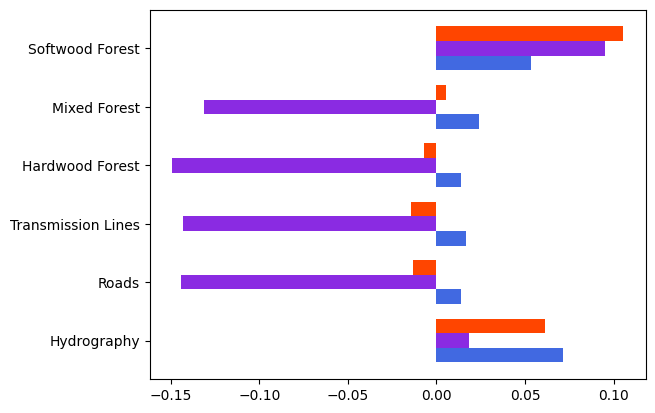

In [ ]:
differences_lg = []
differences_rf = []
differences_gb = []

for i in range(len(variableIndices)-1):
  print(parameters[i])

  mad_test_X, mad_test_y = mixVariable(i+1, X_test , y_test)

  InitialAccuracies = [acc_lg, acc_rf, acc_gb]
  NewAccuracy = []

  print("Logistic")
  lg_score = model_lg.score(mad_test_X, mad_test_y)
  print(lg_score)
  print(acc_lg - lg_score)
  NewAccuracy.append(lg_score)
  differences_lg.append(acc_lg - lg_score)
  # Display
  print(confusion_matrix(mad_test_y, model_lg.predict(mad_test_X)))
  ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(mad_test_y, model_lg.predict(mad_test_X)), display_labels=model_lg.classes_).plot()
  plt.title(f"Logistic Regression {parameters[i]}")
  plt.show()

  print("Random Forest")
  rf_score = model_rf.score(mad_test_X, mad_test_y)
  print(rf_score)
  print(acc_rf - rf_score)
  NewAccuracy.append(rf_score)
  differences_rf.append(acc_rf - rf_score)
  # Display
  print(confusion_matrix(mad_test_y, model_rf.predict(mad_test_X)))
  ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(mad_test_y, model_rf.predict(mad_test_X)), display_labels=model_rf.classes_).plot()
  plt.title(f"Random Forest Classifier {parameters[i]}")
  plt.show()

  print("Gradient Boost")
  gb_score = model_gb.score(mad_test_X, mad_test_y)
  print(gb_score)
  print(acc_gb - gb_score)
  NewAccuracy.append(gb_score)
  differences_gb.append(acc_gb - gb_score)
  # Display
  print(confusion_matrix(y_test, model_gb.predict(mad_test_X)))
  ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(mad_test_y, model_gb.predict(mad_test_X)), display_labels=model_gb.classes_).plot()
  plt.title(f"Gradient Boost Classifier {parameters[i]}")
  plt.show()


  barWidth = 0.25
  fig = plt.subplots()

  br1 = np.arange(len(InitialAccuracies))
  br2 = [x + barWidth for x in br1]
  plt.bar(br1, InitialAccuracies, width=barWidth, label='Initial')
  plt.bar(br2, NewAccuracy, width=barWidth, label="New")
  plt.show()

  print("-"*20)

fig = plt.subplots()
br1 = np.arange(len(differences_lg))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]

plt.bar(br1, differences_lg, width=barWidth, label='Logistic')
plt.bar(br2, differences_rf, width=barWidth, label="Random Forest")
plt.bar(br3, differences_gb, width=barWidth, label="Gradient Boost")
plt.xticks([r + barWidth for r in range(len(differences_lg))], parameters)
plt.legend()
plt.show()

barWidth = 0.25
br1 = np.arange(len(differences_lg))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
fig, ax = plt.subplots()

plt.barh(br1, differences_lg, barWidth, label='Logistic', color="royalblue")
plt.barh(br2, differences_rf, barWidth, label="Random Forest", color="blueviolet")
plt.barh(br3, differences_gb, barWidth, label="Gradient Boost", color="orangered")
plt.yticks([r + barWidth for r in range(len(differences_lg))], parameters)
# plt.legend()
plt.show()

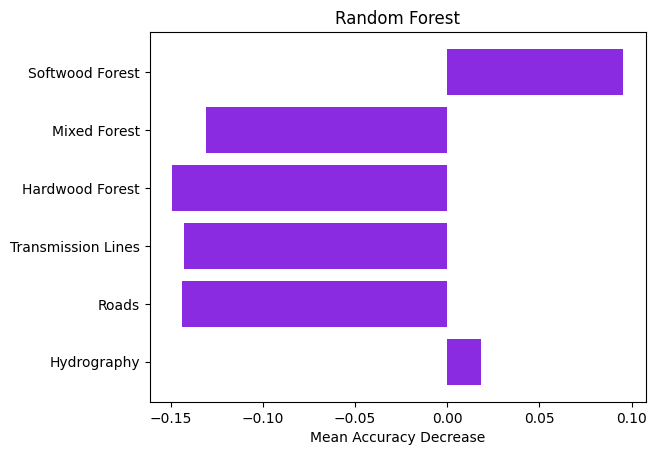

In [ ]:
fig, ax = plt.subplots()
y_pos = np.arange(len(parameters))
ax.barh(y_pos, differences_rf, align='center', color="blueviolet")
ax.set_yticks(y_pos, labels=parameters)
ax.set_xlabel(f"Mean Accuracy Decrease")
ax.set_title(f"Random Forest")
plt.show()

# plt.bar(y_pos, differences_lg, align='center', alpha=0.5)

In [ ]:
print(differences_lg)
print(differences_rf)
print(differences_gb)

[0.07778191291403047, 0.021957573502046857, 0.017119464086341574, 0.010792705619650178, 0.03796055080014882, 0.05396352809825078]
[0.006765761071827248, -0.14098265723855608, -0.1424713062895423, -0.14656509117975436, -0.12609616672869373, 0.11841443989579459]
[0.05661362113881652, -0.013352884257536335, -0.014469371045775947, -0.0029323409006326573, 0.00413874209155185, 0.10276174171938968]
